## Intro to using StatsBomb data for match analysis

In [1]:
pip install statsbombpy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Import the event data 

In [2]:
pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 1.1 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib --upgrade

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 847.2 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.3
    Uninstalling matplotlib-3.6.3:
      Successfully uninstalled matplotlib-3.6.3
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install mplsoccer

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
from statsbombpy import sb
import pandas as pd
from pandas import json_normalize
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects

# We'll only use a vertical pitch for this tutorial
from mplsoccer import VerticalPitch, Sbopen

# Get competitions
comp = sb.competitions()
comp.to_csv('competitions.csv', index=False)



In [2]:
# Get Matches from 2022 FIFA World Cup
df = sb.matches(competition_id=43, season_id=106)
df.to_csv('CSVs/WC_Matches.csv', index=False)

In [3]:

# Find a match_id required
match = 3869118
match_events = sb.events(match_id=match)
team_list =list(match_events.team.unique())

In [4]:
def create_passmap_df(national_team:str,match_events:pd.DataFrame):
    
    first_half = match_events.loc[match_events['period'] == 1] 
    second_half = match_events.loc[match_events['period'] == 2]
    pass_raw = first_half[match_events.type== 'Pass']
    pass_number_raw = pass_raw[['timestamp', 'player', 'pass_recipient']]
    pass_number_raw['pair'] = pass_number_raw.player + pass_number_raw.pass_recipient
    pass_count = pass_number_raw.groupby(['pair']).count().reset_index()
    pass_count = pass_count[['pair', 'timestamp']]
    pass_count.columns = ['pair', 'number_pass']

    avg_loc_df = pass_raw[['team', 'player', 'location']]
    avg_loc_df['pos_x'] = avg_loc_df.location.apply(lambda x: x[0])
    avg_loc_df['pos_y'] = avg_loc_df.location.apply(lambda x: x[1])
    avg_loc_df = avg_loc_df.drop('location', axis=1)

    avg_loc_df = avg_loc_df.groupby(['team','player']).agg({'pos_x': np.mean, 'pos_y': np.mean}).reset_index()

    pass_merge = pass_number_raw.merge(pass_count, on='pair')
    pass_merge = pass_merge[['player', 'pass_recipient', 'number_pass']]
    pass_merge = pass_merge.drop_duplicates()

    avg_loc_df = avg_loc_df[['player', 'pos_x', 'pos_y']]

    pass_cleaned = pass_merge.merge(avg_loc_df, on='player')
    pass_cleaned.rename({'pos_x': 'pos_x_start', 'pos_y': 'pos_y_start'}, axis='columns', inplace=True)

    pass_cleaned = pass_cleaned.merge(avg_loc_df, left_on='pass_recipient', right_on='player', suffixes=['', '_end'])
    pass_cleaned.rename({'pos_x': 'pos_x_end', 'pos_y': 'pos_y_end'}, axis='columns', inplace=True)

    # pass_cleaned = pass_cleaned.drop(['player_name_end'], axis=1)

    player_df = first_half[first_half.team == national_team ].groupby('player').agg({'minute': [min, max]}).reset_index()
    player_df = pd.concat([player_df['player'], player_df['minute']], axis=1)
    player_df['minutes_played'] = player_df['max'] - player_df['min']
    player_df = player_df.sort_values('minutes_played', ascending=False)

    player_names = player_df.player[:11].tolist()

    pass_team = pass_cleaned[pass_cleaned.player.isin(player_names)]
    pass_team = pass_team[pass_team.pass_recipient.isin(player_names)]

    pass_team['width'] = pass_team['number_pass'] / pass_team['number_pass'].max()

    return pass_team



In [5]:
pass_df = create_passmap_df("England",match_events)

/var/folders/6h/6k3qgyf57t36w9tvygh1x2wc0000gn/T/ipykernel_90493/355182805.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_number_raw['pair'] = pass_number_raw.player + pass_number_raw.pass_recipient
/var/folders/6h/6k3qgyf57t36w9tvygh1x2wc0000gn/T/ipykernel_90493/355182805.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_loc_df['pos_x'] = avg_loc_df.location.apply(lambda x: x[0])
/var/folders/6h/6k3qgyf57t36w9tvygh1x2wc0000gn/T/ipykernel_90493/355182805.py:14: SettingWithCopyWarning: 
A va

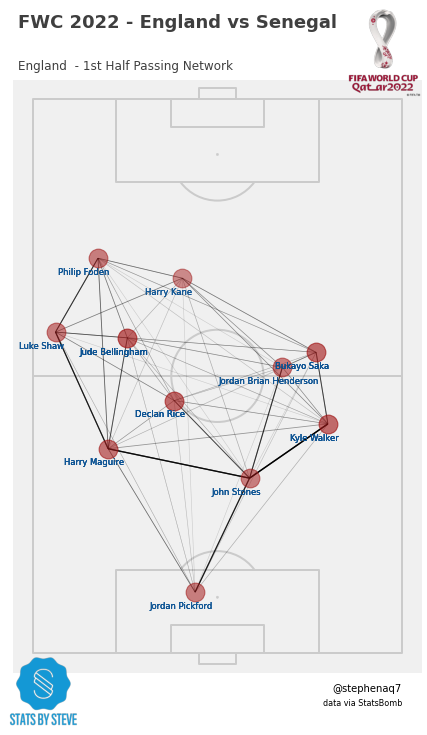

In [6]:
from matplotlib.colors import to_rgba
import matplotlib.style as style
from PIL import Image
import matplotlib.image as image


style.use('fivethirtyeight')

MIN_TRANSPARENCY = 0.1
color = np.array(to_rgba('black'))
color = np.tile(color, (len(pass_df), 1))
c_transparency = pass_df.number_pass / pass_df.number_pass.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

pitch = VerticalPitch(pitch_type='statsbomb', 
    half = False,
    axis = True, 
    # label = True, 
    # tick = True,
    goal_type='box')
    
fig, axs = pitch.grid(figheight=10, title_height=0.08, endnote_space=0, axis=False, 
                      title_space=0, grid_height=0.82, endnote_height=0.05)


pass_lines = pitch.lines(pass_df.pos_x_start, pass_df.pos_y_start,
                         pass_df.pos_x_end, pass_df.pos_y_end, 
                         lw=pass_df.width+0.5,
                         color=color, zorder=1, ax=axs['pitch'])

pass_nodes = pitch.scatter(pass_df.pos_x_start, pass_df.pos_y_start, s=350,
                           color= '#a71c1c', linewidth=1, alpha=0.1, ax=axs['pitch'])

for index, row in pass_df.iterrows():
    pitch.annotate(row.player, xy=(row.pos_x_start-3, row.pos_y_start-3), c='#0b5394', va='center',
                   ha='center', size='small', weight = 'light', family='sans-serif', ax=axs['pitch'],stretch= 'ultra-condensed',style="normal" ,alpha=0.5)
    
# endnote /title
axs['endnote'].text(1, 0.5, '@stephenaq7',
                    va='center', ha='right', fontsize=10)
axs['endnote'].text(1, 0.1, 'data via StatsBomb',
                    va='center', ha='right', fontsize=8)

### Add Fifa WC logo
ax2 = fig.add_axes([0.8, 0.035, 0.175, 1.8])
ax2.axis('off')
img = image.imread('/Users/stephenahiabah/code/statsbomb_project/FWC_Logo.png')
ax2.imshow(img)


### Add Stats by Steve logo
ax3 = fig.add_axes([0.008, -0.028, 0.17, 0.15])
ax3.axis('off')
img = image.imread('/Users/stephenahiabah/code/statsbomb_project/logo_transparent_background.png')
ax3.imshow(img)

axs['title'].text(0.4, 1, f'FWC 2022 - {team_list[0]} vs {team_list[1]} ', weight = 'bold', alpha = .75,
                  va='center', ha='center', fontsize=18)
axs['title'].text(0.25, 0.25, f'{team_list[0]}  - 1st Half Passing Network',
                  va='center', ha='center', alpha = .75, fontsize=12)
plt.savefig(f'Output Visuals/{team_list[0]} - Passing Networks.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
shot_raw = match_events[match_events.type== 'Shot']
shot_raw["location"] = shot_raw["location"].astype(str)
shot_raw["location"] = shot_raw["location"].str[1:]
shot_raw["location"] = shot_raw["location"].str[:-1]
shot_raw[["location"]]
shot_raw[["x", "y"]] = shot_raw["location"].str.split(",", expand=True).astype(np.float32)

/var/folders/6h/6k3qgyf57t36w9tvygh1x2wc0000gn/T/ipykernel_90493/4100415910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shot_raw["location"] = shot_raw["location"].astype(str)
/var/folders/6h/6k3qgyf57t36w9tvygh1x2wc0000gn/T/ipykernel_90493/4100415910.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shot_raw["location"] = shot_raw["location"].str[1:]
/var/folders/6h/6k3qgyf57t36w9tvygh1x2wc0000gn/T/ipykernel_90493/4100415910.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

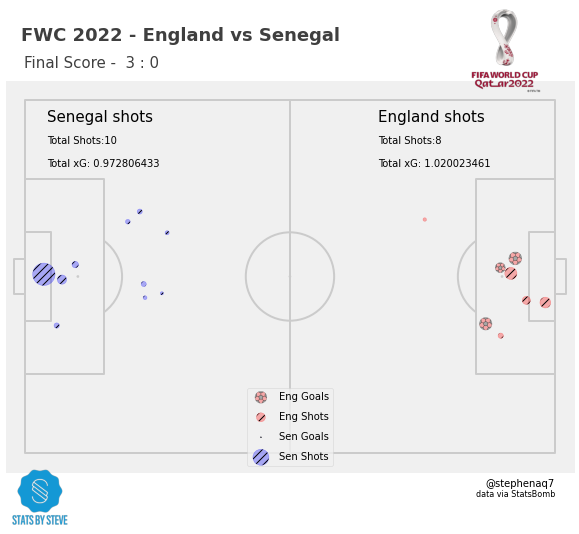

In [8]:
import seaborn as sns
from mplsoccer import Pitch

def generateTeamxGDataFrame(team):
    xg = shot_raw[['team','minute','type','shot_statsbomb_xg','x','y',"shot_outcome"]]
    team_xg = xg[xg['team']==team].reset_index()
    return team_xg
    

def generateCombinedShotMap(team1,team2):
    team1_xg = generateTeamxGDataFrame(team1)
    team2_xg = generateTeamxGDataFrame(team2)
    team1_shots = team1_xg[team1_xg.type=='Shot']

    team1_goals = team1_shots[team1_shots.shot_outcome == 'Goal'].copy()
    team1_non_goals = team1_shots[team1_shots.shot_outcome != 'Goal'].copy()

    team2_shots = team2_xg[team2_xg.type=='Shot']

    team2_goals = team2_shots[team2_shots.shot_outcome == 'Goal'].copy()
    team2_non_goals = team2_shots[team2_shots.shot_outcome != 'Goal'].copy()

    pitch = Pitch(pitch_type='statsbomb', 
    half = False,
    axis = True, 
    # label = True, 
    # tick = True,
    goal_type='box')
    fig, ax = pitch.grid(grid_height=0.6, title_height=0.06, axis=False,endnote_height=0.04, title_space=0, endnote_space=0)

# team 1 shots and goals
    pitch.scatter(team1_goals.x, team1_goals.y, alpha = 0.3, s = team1_goals.shot_statsbomb_xg*800, c = "red", ax=ax['pitch'], marker='football',label="Eng Goals")
    pitch.scatter(team1_non_goals.x, team1_non_goals.y, alpha = 0.3, s = team1_non_goals.shot_statsbomb_xg*800, c = "red", ax=ax['pitch'],hatch='///',label="Eng Shots")

# team 2 shots and goals

    pitch.scatter(120-team2_goals.x, 80-team2_goals.y, alpha = 0.3, s = team2_goals.shot_statsbomb_xg*800, c = "blue", ax=ax['pitch'], marker='football',label="Sen Goals")
    pitch.scatter(120-team2_non_goals.x, 80-team2_non_goals.y, alpha = 0.3, s = team2_non_goals.shot_statsbomb_xg*800, c = "blue", hatch='///', ax=ax['pitch'],label="Sen Shots")


    ax['pitch'].text(5, 5, team2 + ' shots',size=15)
    ax['pitch'].text(5, 10, f'Total Shots:' + str(len(team2_xg)),size=10)
    ax['pitch'].text(5, 15, f'Total xG: ' + str((team2_xg.shot_statsbomb_xg.sum())),size=10)
    ax['pitch'].text(80, 5, team1 + ' shots',size=15)
    ax['pitch'].text(80, 10, f'Total Shots:' + str(len(team1_xg)),size=10)
    ax['pitch'].text(80, 15, f'Total xG: ' + str(team1_xg.shot_statsbomb_xg.sum()),size=10)

 
                           
    ax['pitch'].legend(labelspacing=1, loc="lower center")

### Add Fifa WC logo
    ax2 = fig.add_axes([0.8, 0.04, 0.12, 1.6])
    ax2.axis('off')
    img = image.imread('/Users/stephenahiabah/code/statsbomb_project/FWC_Logo.png')
    ax2.imshow(img)


    ### Add Stats by Steve logo
    ax3 = fig.add_axes([0.03, 0.1, 0.1, 0.1])
    ax3.axis('off')
    img = image.imread('/Users/stephenahiabah/code/statsbomb_project/logo_transparent_background.png')
    ax3.imshow(img)

    ax['title'].text(0.3, 1.2, f'FWC 2022 - {team_list[0]} vs {team_list[1]} ', weight = 'bold', alpha = .75,
                    va='center', ha='center', fontsize=18)
    ax['title'].text(0.13, 0.5, f'Final Score -  {str(len(team1_goals))} : {str(len(team2_goals))} ',  alpha = .75,
                va='center', ha='center', fontsize=15)
    
    # endnote /title    
    ax['endnote'].text(1, 0.5, '@stephenaq7',
                    va='center', ha='right', fontsize=10)
    ax['endnote'].text(1, 0.1, 'data via StatsBomb',
                    va='center', ha='right', fontsize=8)

 # calling the function
generateCombinedShotMap('England','Senegal')


In [9]:
match_events.columns

Index(['50_50', 'ball_receipt_outcome', 'ball_recovery_recovery_failure',
       'block_deflection', 'block_offensive', 'carry_end_location',
       'clearance_aerial_won', 'clearance_body_part', 'clearance_head',
       'clearance_left_foot', 'clearance_right_foot', 'counterpress',
       'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun', 'duel_outcome',
       'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_won_advantage', 'foul_won_defensive',
       'goalkeeper_body_part', 'goalkeeper_end_location', 'goalkeeper_outcome',
       'goalkeeper_position', 'goalkeeper_technique', 'goalkeeper_type', 'id',
       'index', 'interception_outcome', 'location', 'match_id', 'minute',
       'miscontrol_aerial_won', 'off_camera', 'out', 'pass_aerial_won',
       'pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_end_location', 'pass_goal_assist', 'pass_height',
       'pass_inswinging', 'pass_length',

In [10]:
touches_raw = match_events.copy()
touches = touches_raw[['team','player','location']]
touches_team = touches[touches['team']=="England"].reset_index()

touches_team.drop(touches_team[touches_team['location'] == "a"].index, inplace = True)
# touches_team = touches_team.loc[lambda x: x['location'] != 'a']

touches_team["location"] = touches_team["location"].astype(str)
touches_team["location"] = touches_team["location"].str[1:]
touches_team["location"] = touches_team["location"].str[:-1]
touches_team.drop(touches_team[touches_team['location'] == "a"].index, inplace = True)
touches_team[["x", "y"]] = touches_team["location"].str.split(",", expand=True).astype(np.float32)
touches_team

,index,team,player,location,x,y
3,15,England,Philip Foden,"39.8, 7.5",39.799999,7.500000
4,16,England,Declan Rice,"15.9, 20.5",15.900000,20.500000
5,17,England,Jordan Pickford,"2.7, 32.8",2.700000,32.799999
6,26,England,Declan Rice,"64.1, 10.6",64.099998,10.600000
7,27,England,Luke Shaw,"67.0, 0.1",67.000000,0.100000
...,...,...,...,...,...,...
2068,3469,England,Harry Kane,"104.3, 50.7",104.300003,50.700001
2069,3471,England,Bukayo Saka,"107.7, 53.4",107.699997,53.400002
2070,3472,England,Harry Kane,"90.5, 27.1",90.500000,27.100000
2071,3473,England,Bukayo Saka,"111.0, 35.9",111.000000,35.900002


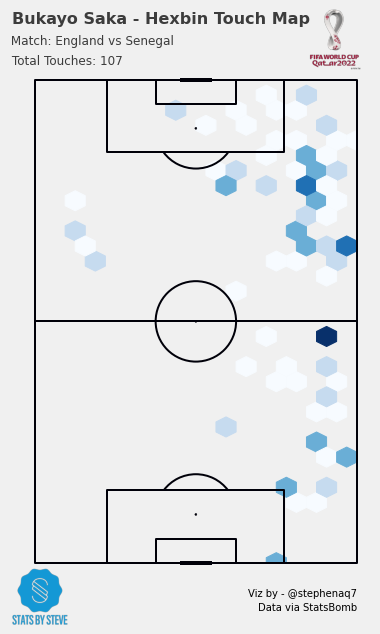

In [11]:
style.use('fivethirtyeight')


player_name = 'Bukayo Saka'
touches_player = touches_team.loc[lambda x: x['player'] == player_name]

pitch = VerticalPitch(line_color='#000009', line_zorder=2, )
fig, axs = pitch.grid(figheight=10, title_height=0.08, endnote_space=0,
                      title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,)
hexmap = pitch.hexbin(touches_player.x, touches_player.y, ax=axs['pitch'], 
                      gridsize=(16, 16), cmap="Blues")
### Add Fifa WC logo
ax2 = fig.add_axes([0.8, 0.035, 0.14, 1.7])
ax2.axis('off')
img = image.imread('/Users/stephenahiabah/code/statsbomb_project/FWC_Logo.png')
ax2.imshow(img)


### Add Stats by Steve logo
ax3 = fig.add_axes([0, 0.06, 0.16, 0.1])
ax3.axis('off')
img = image.imread('/Users/stephenahiabah/code/statsbomb_project/logo_transparent_background.png')
ax3.imshow(img)

axs['title'].text(0.4, 0.7, f'{player_name} - Hexbin Touch Map ', weight = 'bold', alpha = .75,
                 ha='center', fontsize=16)

axs['title'].text(0.185, 0.4, f' Match: {team_list[0]} vs {team_list[1]}  ', alpha = .75,
                  va='center', ha='center', fontsize=12)

axs['title'].text(0.107, 0.05, f' Total Touches: {len(touches_player)}  ', alpha = .75,
                  va='center', ha='center', fontsize=12)

axs['endnote'].text(1, 0.7, 'Viz by - @stephenaq7', va='center', ha='right', fontsize=10)
axs['endnote'].text(1, 0.4, 'Data via StatsBomb', va='center', ha='right', fontsize=10)
plt.savefig(f'Output Visuals/{player_name} - Hexbin Touch Map.png', dpi=300, bbox_inches='tight')

In [12]:
player_passes_raw = match_events.copy()
player_passes_raw = player_passes_raw[['team','player','location','pass_end_location',"pass_outcome"]]
player_passes_raw = player_passes_raw[player_passes_raw['team']=="England"].reset_index()

player_passes_raw.drop(player_passes_raw[player_passes_raw['location'] == "a"].index, inplace = True)
player_passes_raw.drop(player_passes_raw[player_passes_raw['pass_end_location'] == "a"].index, inplace = True)
# touches_team = touches_team.loc[lambda x: x['location'] != 'a']

player_passes_raw["location"] = player_passes_raw["location"].astype(str)
player_passes_raw["location"] = player_passes_raw["location"].str[1:]
player_passes_raw["location"] = player_passes_raw["location"].str[:-1]
player_passes_raw.drop(player_passes_raw[player_passes_raw['location'] == "a"].index, inplace = True)
player_passes_raw[["x", "y"]] = player_passes_raw["location"].str.split(",", expand=True).astype(np.float32)


player_passes_raw["pass_end_location"] = player_passes_raw["pass_end_location"].astype(str)
player_passes_raw["pass_end_location"] = player_passes_raw["pass_end_location"].str[1:]
player_passes_raw["pass_end_location"] = player_passes_raw["pass_end_location"].str[:-1]
player_passes_raw.drop(player_passes_raw[player_passes_raw['pass_end_location'] == "a"].index, inplace = True)
player_passes_raw[["end_x", "end_y"]] = player_passes_raw["pass_end_location"].str.split(",", expand=True).astype(np.float32)


player_passes_raw

,index,team,player,location,pass_end_location,pass_outcome,x,y,end_x,end_y
3,15,England,Philip Foden,"39.8, 7.5","18.6, 19.8",NaN,39.799999,7.500000,18.600000,19.799999
4,16,England,Declan Rice,"15.9, 20.5","2.9, 32.8",NaN,15.900000,20.500000,2.900000,32.799999
5,17,England,Jordan Pickford,"2.7, 32.8","24.6, 0.1",Out,2.700000,32.799999,24.600000,0.100000
6,26,England,Declan Rice,"64.1, 10.6","74.0, 3.1",NaN,64.099998,10.600000,74.000000,3.100000
7,27,England,Luke Shaw,"67.0, 0.1","46.7, 21.7",NaN,67.000000,0.100000,46.700001,21.700001
...,...,...,...,...,...,...,...,...,...,...
624,1013,England,Kalvin Phillips,"76.0, 57.2","92.4, 25.9",NaN,76.000000,57.200001,92.400002,25.900000
625,1014,England,Jack Grealish,"98.6, 28.1","115.5, 22.5",NaN,98.599998,28.100000,115.500000,22.500000
626,1015,England,Luke Shaw,"117.2, 22.5","117.8, 45.9",NaN,117.199997,22.500000,117.800003,45.900002
627,1026,England,Luke Shaw,"19.9, 29.5","29.0, 33.4",NaN,19.900000,29.500000,29.000000,33.400002


In [13]:
mask_complete = player_passes_raw.pass_outcome.isnull()

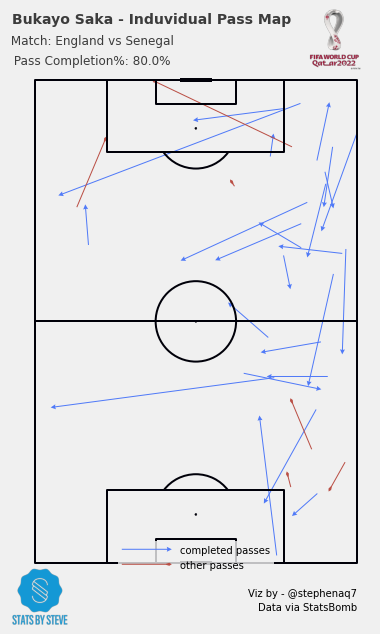

In [14]:
style.use('fivethirtyeight')


player_name = 'Bukayo Saka'

passes_player = player_passes_raw.loc[lambda x: x['player'] == player_name]

pitch = VerticalPitch(line_color='#000009', line_zorder=2, )
fig, axs = pitch.grid(figheight=10, title_height=0.08, endnote_space=0,
                      title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,)
# Plot the completed passes
pitch.arrows(passes_player[mask_complete].x, passes_player[mask_complete].y,
             passes_player[mask_complete].end_x, passes_player[mask_complete].end_y, width=1,
             headwidth=5, headlength=5, color='#507af8', ax=axs['pitch'], label='completed passes')

# Plot the other passes
pitch.arrows(passes_player[~mask_complete].x, passes_player[~mask_complete].y,
             passes_player[~mask_complete].end_x, passes_player[~mask_complete].end_y, width=1,
             headwidth=3, headlength=2.5, headaxislength=6,
             color='#ba4f45', ax=axs['pitch'], label='other passes')

# Set up the legend
legend = axs['pitch'].legend(handlelength=5, edgecolor='None', fontsize=10, loc='lower center')

### Add Fifa WC logo
ax2 = fig.add_axes([0.8, 0.035, 0.14, 1.7])
ax2.axis('off')
img = image.imread('/Users/stephenahiabah/code/statsbomb_project/FWC_Logo.png')
ax2.imshow(img)


### Add Stats by Steve logo
ax3 = fig.add_axes([0, 0.06, 0.16, 0.1])
ax3.axis('off')
img = image.imread('/Users/stephenahiabah/code/statsbomb_project/logo_transparent_background.png')
ax3.imshow(img)

axs['title'].text(0.37, 0.7, f'{player_name} - Induvidual Pass Map ', weight = 'bold', alpha = .75,
                 ha='center', fontsize=14)

axs['title'].text(0.185, 0.4, f' Match: {team_list[0]} vs {team_list[1]}  ', alpha = .75,
                  va='center', ha='center', fontsize=12)

axs['title'].text(0.185, 0.05, f' Pass Completion%: {(len(passes_player[mask_complete])/len(passes_player))*100}%  ', alpha = .75,
                  va='center', ha='center', fontsize=12)

axs['endnote'].text(1, 0.7, 'Viz by - @stephenaq7', va='center', ha='right', fontsize=10)
axs['endnote'].text(1, 0.4, 'Data via StatsBomb', va='center', ha='right', fontsize=10)
plt.savefig(f'Output Visuals/{player_name} - Hexbin Touch Map.png', dpi=300, bbox_inches='tight')


In [16]:
parser = Sbopen()
events, related, freeze, tactics = parser.event(match)
lineup = parser.lineup(match)

In [17]:
# dataframe with player_id and when they were subbed off
time_off = events.loc[(events.type_name == 'Substitution'),
                      ['player_id', 'minute']]
time_off.rename({'minute': 'off'}, axis='columns', inplace=True)
# dataframe with player_id and when they were subbed on
time_on = events.loc[(events.type_name == 'Substitution'),
                     ['substitution_replacement_id', 'minute']]
time_on.rename({'substitution_replacement_id': 'player_id',
                'minute': 'on'}, axis='columns', inplace=True)
players_on = time_on.player_id
# merge on times subbed on/off
lineup = lineup.merge(time_on, on='player_id', how='left')
lineup = lineup.merge(time_off, on='player_id', how='left')

In [18]:
# filter the tactics lineup for the starting xi
starting_ids = events[events.type_name == 'Starting XI'].id
starting_xi = tactics[tactics.id.isin(starting_ids)]
starting_players = starting_xi.player_id

# filter the lineup for players that actually played
mask_played = ((lineup.on.notnull()) | (lineup.off.notnull()) |
               (lineup.player_id.isin(starting_players)))
lineup = lineup[mask_played].copy()

# get the first position for each player and add this to the lineup dataframe
player_positions = (events[['player_id', 'position_id']]
                    .dropna(how='any', axis='rows')
                    .drop_duplicates('player_id', keep='first'))
lineup = lineup.merge(player_positions, how='left', on='player_id')

# add on the position abbreviation
formation_dict = {1: 'GK', 2: 'RB', 3: 'RCB', 4: 'CB', 5: 'LCB', 6: 'LB', 7: 'RWB',
                  8: 'LWB', 9: 'RDM', 10: 'CDM', 11: 'LDM', 12: 'RM', 13: 'RCM',
                  14: 'CM', 15: 'LCM', 16: 'LM', 17: 'RW', 18: 'RAM', 19: 'CAM',
                  20: 'LAM', 21: 'LW', 22: 'RCF', 23: 'ST', 24: 'LCF', 25: 'SS'}
lineup['position_abbreviation'] = lineup.position_id.map(formation_dict)

# sort the dataframe so the players are
# in the order of their position (if started), otherwise in the order they came on
lineup['start'] = lineup.player_id.isin(starting_players)
lineup.sort_values(['team_name', 'start', 'on', 'position_id'],
                   ascending=[True, False, True, True], inplace=True)

In [19]:
# filter the lineup for England players
# if you want the other team set team = team2
team1, team2 = lineup.team_name.unique()  # England (team1), Sengeal (team2)
team = team1
lineup_team = lineup[lineup.team_name == team].copy()

# filter the events to exclude some set pieces
set_pieces = ['Throw-in', 'Free Kick', 'Corner', 'Kick Off', 'Goal Kick']
# for the team pass map
pass_receipts = events[(events.team_name == team) & (events.type_name == 'Ball Receipt')].copy()
# for the player pass maps
passes_excl_throw = events[(events.team_name == team) & (events.type_name == 'Pass') &
                           (events.sub_type_name != 'Throw-in')].copy()

# identify how many players played and how many subs were used
# we will use this in the loop for only plotting pass maps for as
# many players who played
num_players = len(lineup_team)
num_sub = num_players - 11

In [20]:
# add padding to the top so we can plot the titles, and raise the pitch lines
pitch = Pitch(pad_top=10, line_zorder=2)

# arrow properties for the sub on/off
green_arrow = dict(arrowstyle='simple, head_width=0.7',
                   connectionstyle="arc3,rad=-0.8", fc="green", ec="green")
red_arrow = dict(arrowstyle='simple, head_width=0.7',
                 connectionstyle="arc3,rad=-0.8", fc="red", ec="red")

# a fontmanager object for using a google font
# fm_scada = FontManager('https://raw.githubusercontent.com/googlefonts/scada/main/fonts/ttf/'
#                        'Scada-Regular.ttf')

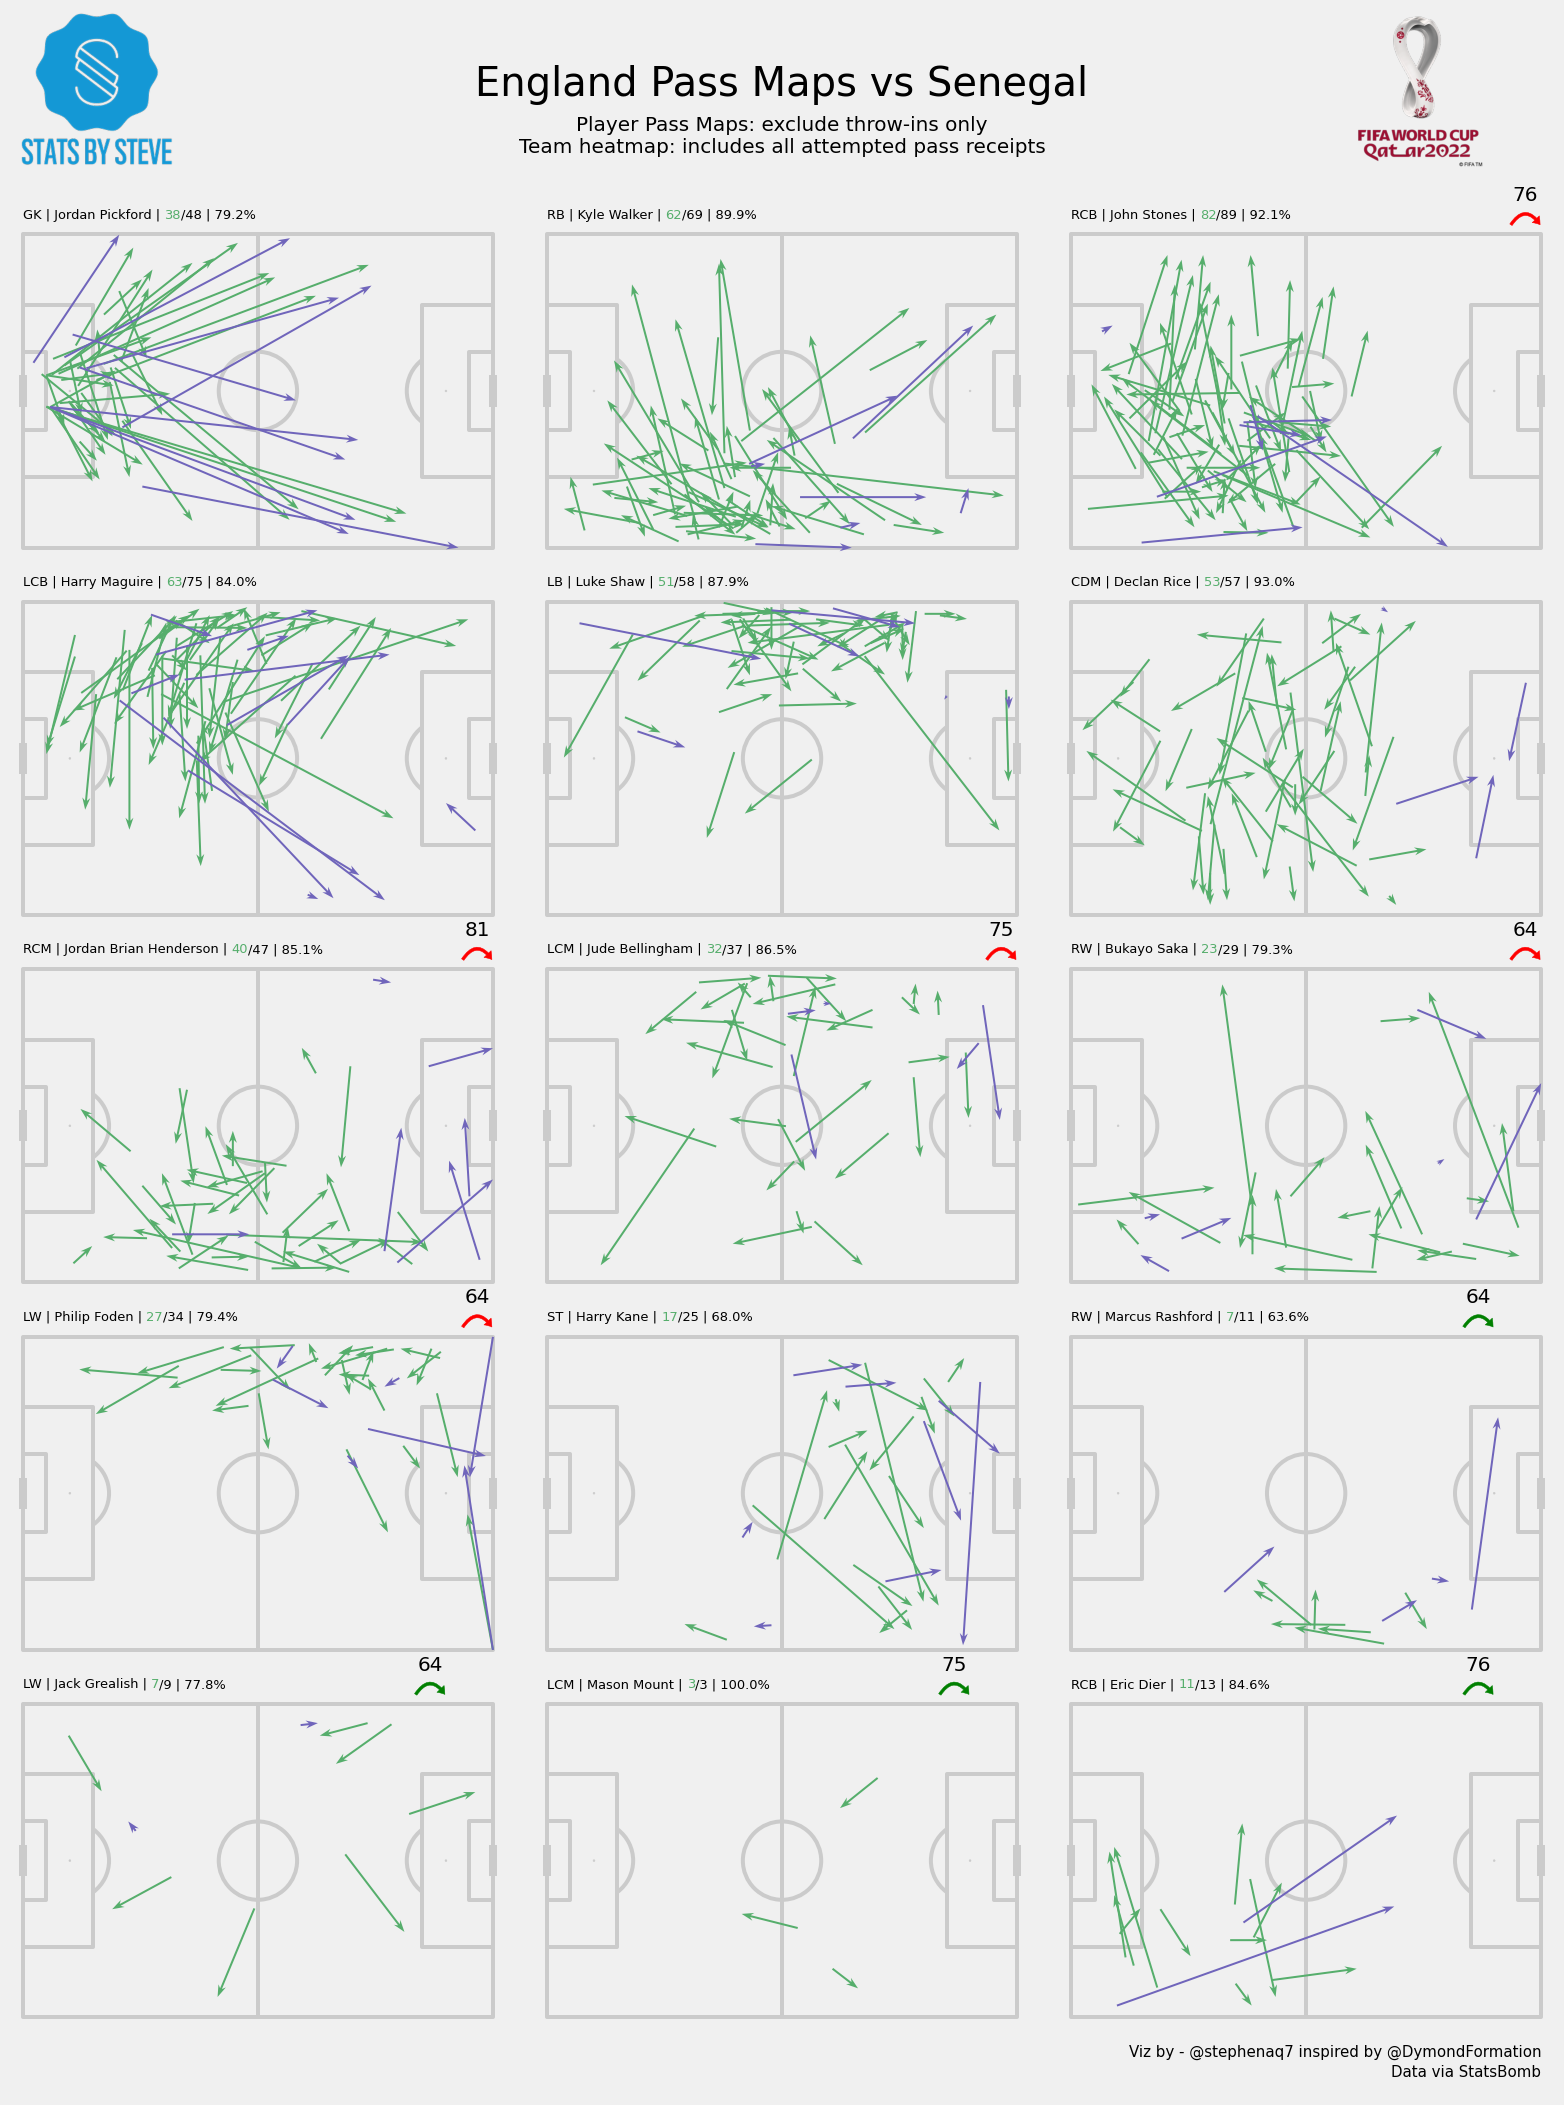

In [46]:
import warnings

import cmasher as cmr

from highlight_text import ax_text

# filtering out some highlight_text warnings - the warnings aren't correct as the
# text fits inside the axes.
warnings.simplefilter("ignore", UserWarning)

# plot the 5 * 3 grid
fig, axs = pitch.grid(nrows=5, ncols=3, figheight=30,
                      endnote_height=0.03, endnote_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      title_height=0.08, grid_height=0.84)
# cycle through the grid axes and plot the player pass maps
for idx, ax in enumerate(axs['pitch'].flat):
    # only plot the pass maps up to the total number of players
    if idx < num_players:
        # filter the complete/incomplete passes for each player (excudes throw-ins)
        lineup_player = lineup_team.iloc[idx]
        player_id = lineup_player.player_id
        player_pass = passes_excl_throw[passes_excl_throw.player_id == player_id]
        complete_pass = player_pass[player_pass.outcome_name.isnull()]
        incomplete_pass = player_pass[player_pass.outcome_name.notnull()]

        # plot the arrows
        pitch.arrows(complete_pass.x, complete_pass.y,
                     complete_pass.end_x, complete_pass.end_y,
                     color='#56ae6c', width=2, headwidth=4, headlength=6, ax=ax)
        pitch.arrows(incomplete_pass.x, incomplete_pass.y,
                     incomplete_pass.end_x, incomplete_pass.end_y,
                     color='#7065bb', width=2, headwidth=4, headlength=6, ax=ax)


        total_pass = len(complete_pass) + len(incomplete_pass)
        annotation_string = (f'{lineup_player.position_abbreviation} | '
                             f'{lineup_player.player_name} | '
                             f'<{len(complete_pass)}>/{total_pass} | '
                             f'{round(100 * len(complete_pass)/total_pass, 1)}%')
        ax_text(0, -5, annotation_string, ha='left', va='center', fontsize=13,
                highlight_textprops=[{"color": '#56ae6c'}], ax=ax)

        # add information for subsitutions on/off and arrows
        if not np.isnan(lineup_team.iloc[idx].off):
            ax.text(116, -10, str(lineup_team.iloc[idx].off.astype(int)), fontsize=20,
                    ha='center', va='center')
            ax.annotate('', (120, -2), (112, -2), arrowprops=red_arrow)
        if not np.isnan(lineup_team.iloc[idx].on):
            ax.text(104, -10, str(lineup_team.iloc[idx].on.astype(int)), fontsize=20,
                    ha='center', va='center')
            ax.annotate('', (108, -2), (100, -2), arrowprops=green_arrow)



# remove unused axes (if any)
for ax in axs['pitch'].flat[11 + num_sub:-1]:
    ax.remove()





# title text
axs['title'].text(0.5, 0.65, f'{team1} Pass Maps vs {team2}', fontsize=40,
                  va='center', ha='center')
SUB_TEXT = ('Player Pass Maps: exclude throw-ins only\n'
            'Team heatmap: includes all attempted pass receipts')
axs['title'].text(0.5, 0.35, SUB_TEXT, fontsize=20,
                  va='center', ha='center')
# plot logos (same height as the title_ax)

### Add Fifa WC logo
ax2 = fig.add_axes([0.85, 0.025, 0.08, 1.85])
ax2.axis('off')
img = image.imread('/Users/stephenahiabah/code/statsbomb_project/FWC_Logo.png')
ax2.imshow(img)


### Add Stats by Steve logo
ax3 = fig.add_axes([0.03, 0.9, 0.1, 0.1])
ax3.axis('off')
img = image.imread('/Users/stephenahiabah/code/statsbomb_project/logo_transparent_background.png')
ax3.imshow(img)


# endnote text
axs['endnote'].text(1, 0.7, 'Viz by - @stephenaq7 inspired by @DymondFormation', va='center', ha='right', fontsize=15)
axs['endnote'].text(1, 0.4, 'Data via StatsBomb', va='center', ha='right', fontsize=15)


plt.show()  # If you are using a Jupyter notebook you do not need this line